[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [3]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")
llm.invoke(messages)

AIMessage(content='Ocean mammals, also known as marine mammals, include a fascinating variety of species beyond whales. Here are some groups you might want to explore:\n\n1. **Dolphins and Porpoises**: These are part of the cetacean family, like whales. Dolphins are typically more social and known for their intelligence and complex behaviors. Porpoises are generally smaller and less acrobatic than dolphins.\n\n2. **Seals, Sea Lions, and Walruses (Pinnipeds)**: These marine mammals are well adapted to life both in water and on land. Seals are known for their streamlined bodies and lack of visible ear flaps, while sea lions have external ears and can "walk" on land using their flippers. Walruses are notable for their large tusks and whiskers.\n\n3. **Manatees and Dugongs (Sirenians)**: Often referred to as "sea cows," these herbivorous mammals graze on seagrasses and are typically found in warm coastal waters. Manatees are mainly found in the Caribbean and the Atlantic Ocean, while dugon

We can run our chat model in a simple graph with `MessagesState`.

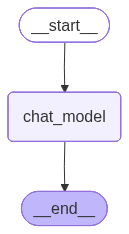

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Beyond whales, there are several fascinating marine mammals you might want to explore:

1. **Dolphins**: Closely related to whales and porpoises, dolphins are known for their intelligence and playful behavior. There are over 40 species, including the well-known bottlenose dolphin.

2. **Porpoises**: Often confused with dolphins, porpoises are generally smaller and have shorter snouts. They include species like the harbor porpoise and the vaquita, which is critically endangered.

3. **Seals**: Found in various climates, seals are divided into earless seals (true seals) and eared seals (sea lions and fur seals). No

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

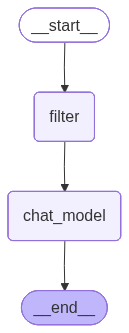

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there are several fascinating ocean mammals you might want to explore:

1. **Dolphins**: Highly intelligent creatures known for their playful behavior and sophisticated communication abilities. There are several species, including the bottlenose dolphin and the orca (killer whale), which is actually a type of dolphin.

2. **Porpoises**: Similar to dolphins but typically smaller, porpoises have distinctively different facial characteristics and are found in various oceans around the world.

3. **Seals**: These are pinnipeds, a group that also includes sea lions and walruses. Seals are adapted to li

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

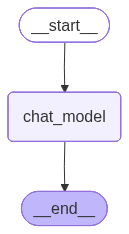

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there are several fascinating ocean mammals you might want to explore:

1. **Dolphins**: Highly intelligent creatures known for their playful behavior and sophisticated communication abilities. There are several species, including the bottlenose dolphin and the orca (killer whale), which is actually a type of dolphin.

2. **Porpoises**: Similar to dolphins but typically smaller, porpoises have distinctively

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Besides whales, there are several fascinating ocean mammals you might want to explore:

1. **Dolphins**: Highly intelligent creatures known for their playful behavior and sophisticated communication abilities. There are several species, including the bottlenose dolphin and the orca (killer whale), which is actually a type of dolphin.

2. **Porpoises**: Similar to dolphins but typically smaller, porpoises have distinctively

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

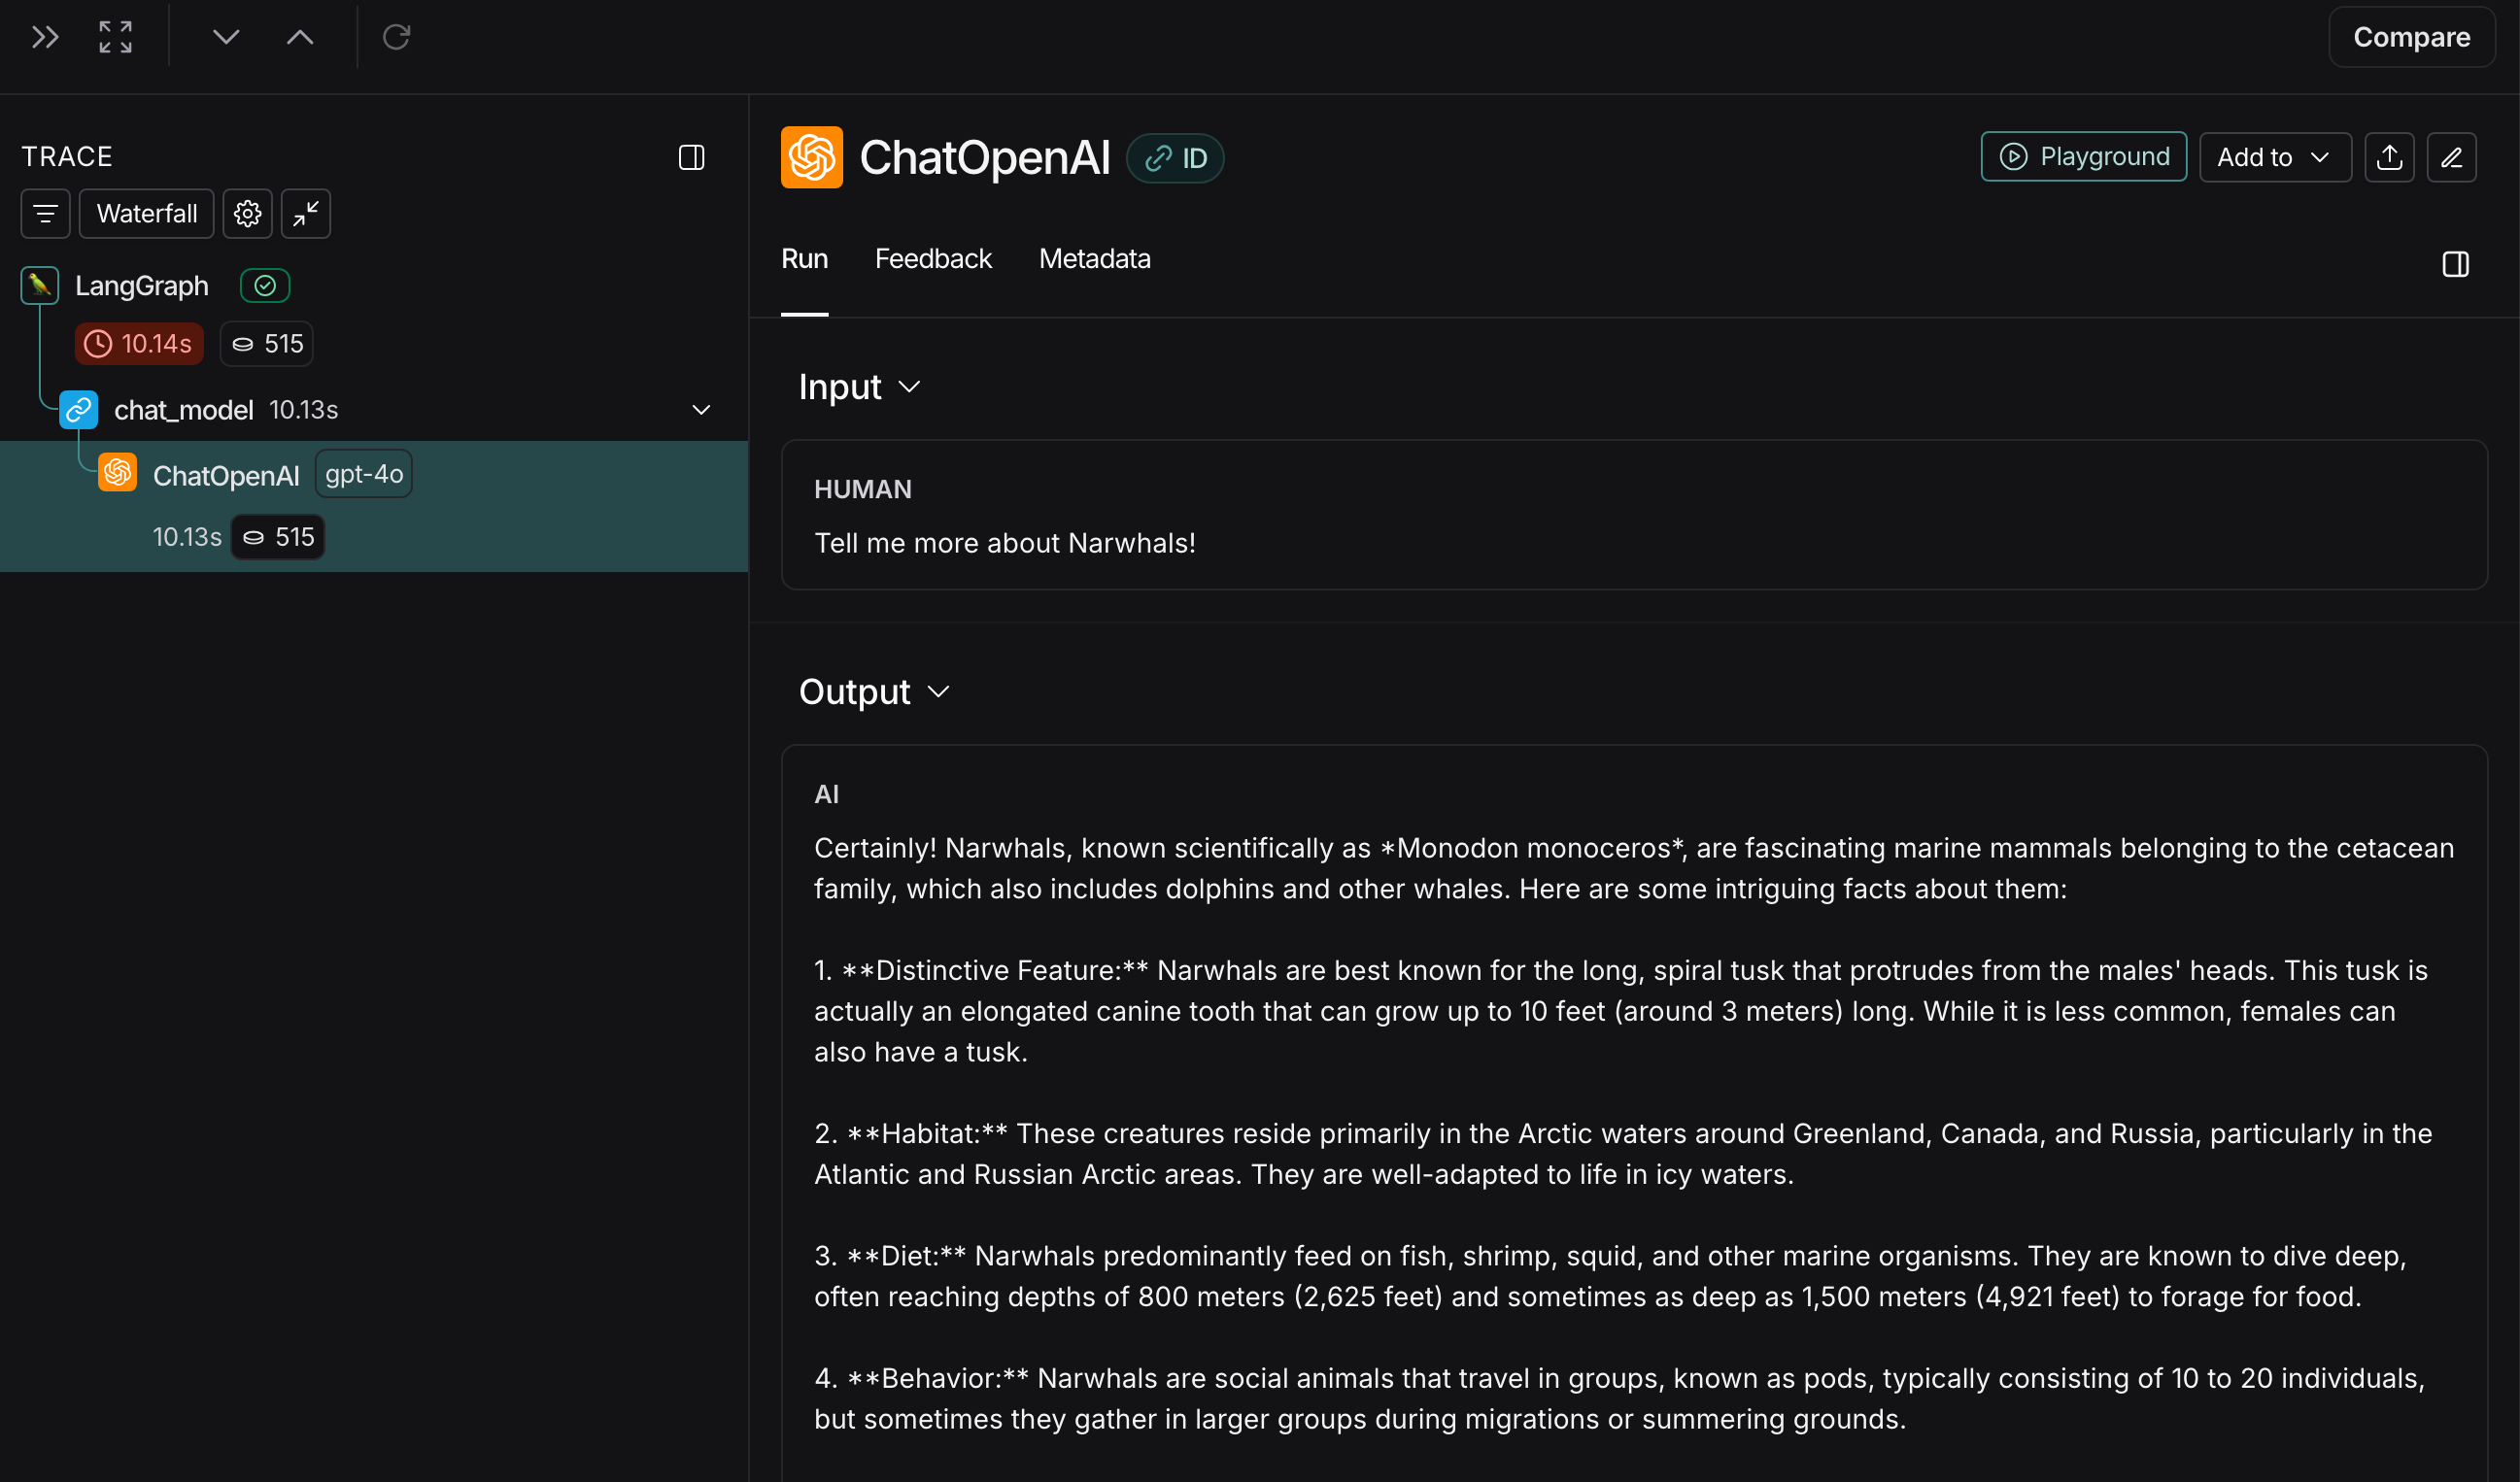

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

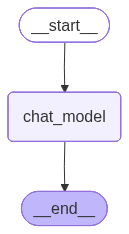

In [14]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [16]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False
        )

[HumanMessage(content='Tell me where Orcas live!', additional_kwargs={}, response_metadata={}, name='Lance')]

In [17]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r

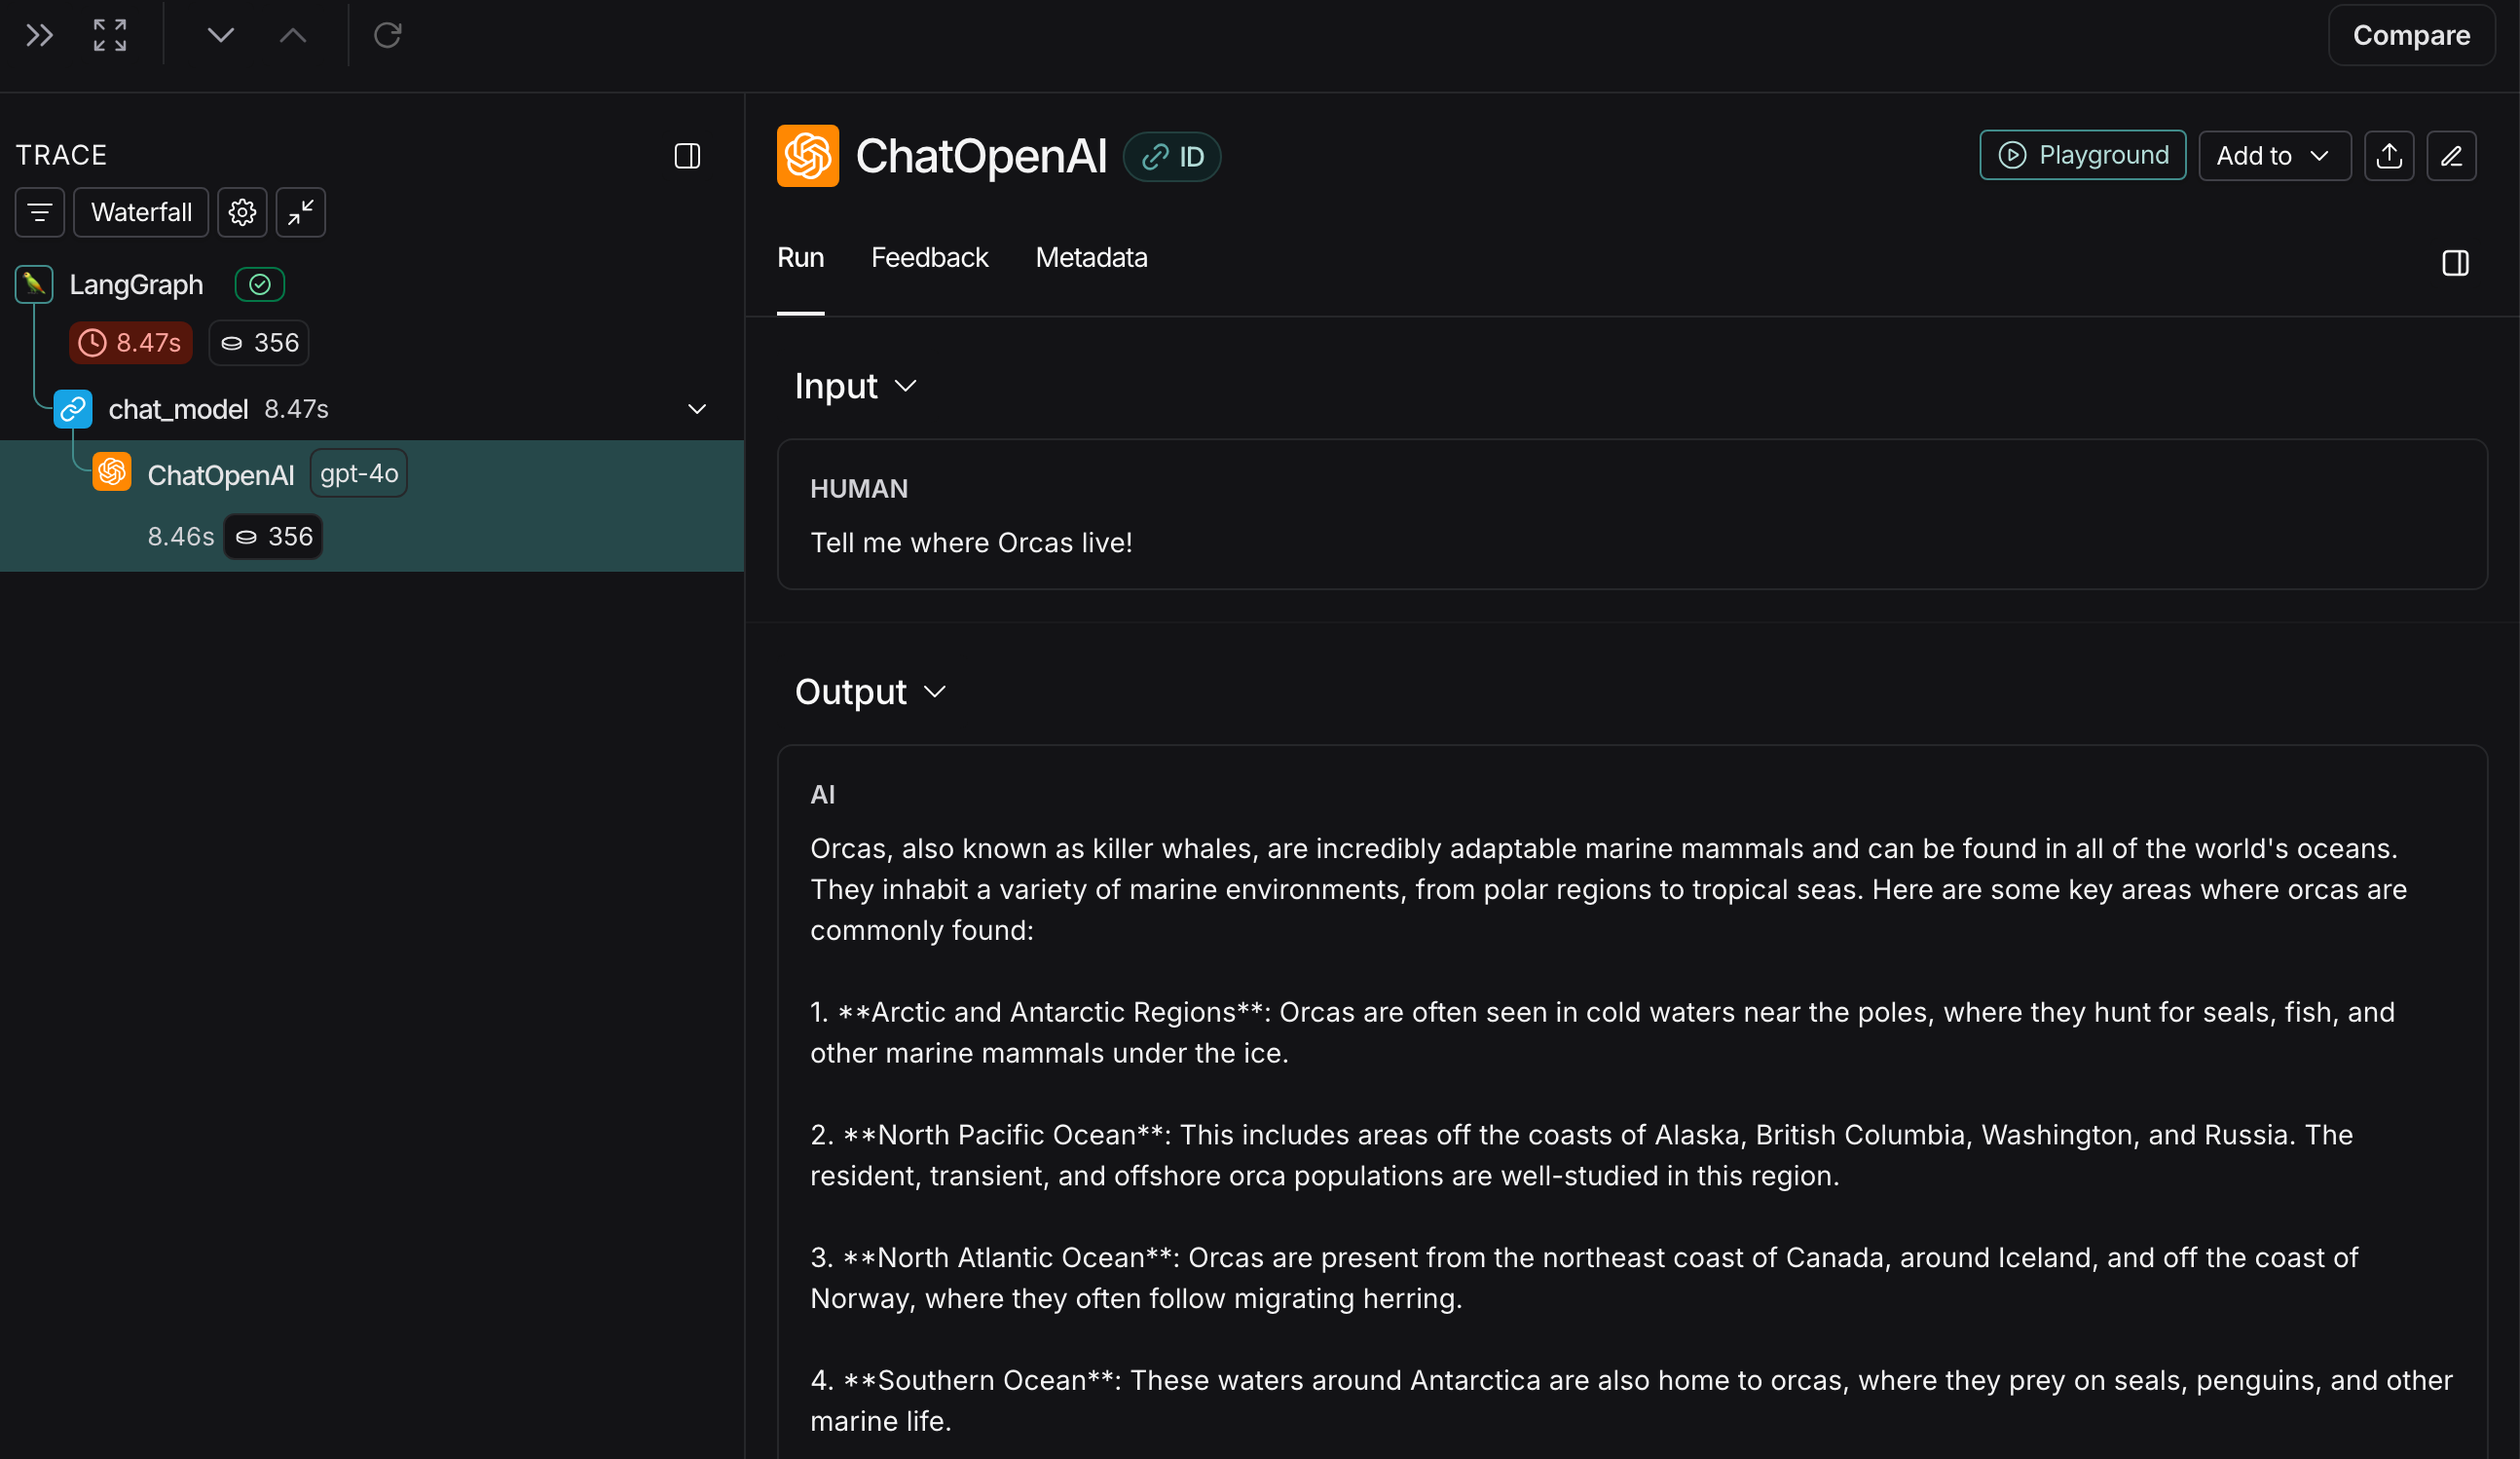

# SELF-EXERCISE:

Message Filtering Graph (Keep last 3 messages)

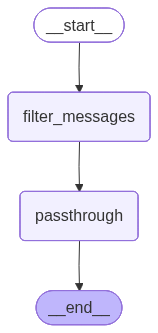

In [18]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage
from IPython.display import Image, display

def filter_last_3_messages(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-3]]
    return {"messages": delete_messages}

def passthrough_node(state: MessagesState):
    return {"messages": state["messages"]}

builder = StateGraph(MessagesState)
builder.add_node("filter_messages", filter_last_3_messages)
builder.add_node("passthrough", passthrough_node)
builder.add_edge(START, "filter_messages")
builder.add_edge("filter_messages", "passthrough")
builder.add_edge("passthrough", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [19]:
msgs = [
    HumanMessage(content="Hello!", id="1"),
    AIMessage(content="Hi there! What can I do for you today?", id="2"),
    HumanMessage(content="Can you tell me about renewable energy?", id="3"),
    AIMessage(content="Sure! Renewable energy includes solar, wind, and hydro power.", id="4"),
    HumanMessage(content="Thanks for the info!", id="5"),
]

result = graph.invoke({"messages": msgs})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Can you tell me about renewable energy?
================================== Ai Message ==================================

Sure! Renewable energy includes solar, wind, and hydro power.
================================ Human Message =================================

Thanks for the info!


Message Filtering Graph (Keep last 2 messages for model input)

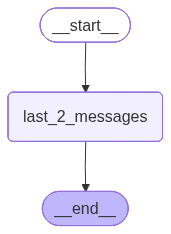

In [20]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import AIMessage, HumanMessage

def last_2_messages_node(state: MessagesState):
    return {"messages": state["messages"][-2:]}

builder = StateGraph(MessagesState)
builder.add_node("last_2_messages", last_2_messages_node)
builder.add_edge(START, "last_2_messages")
builder.add_edge("last_2_messages", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
msgs = [
    HumanMessage(content="What is the tallest mountain?", id="1"),
    AIMessage(content="Mount Everest is the tallest mountain.", id="2"),
    HumanMessage(content="How high is it?", id="3"),
    AIMessage(content="It is 8,848 meters tall.", id="4"),
    HumanMessage(content="Are there any other high mountains nearby?", id="5"),
    AIMessage(content="Yes, K2 and Kangchenjunga are also very tall.", id="6"),
]

result = graph.invoke({"messages": msgs})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the tallest mountain?
================================== Ai Message ==================================

Mount Everest is the tallest mountain.
================================ Human Message =================================

How high is it?
================================== Ai Message ==================================

It is 8,848 meters tall.
================================ Human Message =================================

Are there any other high mountains nearby?
================================== Ai Message ==================================

Yes, K2 and Kangchenjunga are also very tall.


Automatic Message Trimming Based on Token Limit

In [26]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import AIMessage, HumanMessage, trim_messages
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4")

def trim_to_token_limit(state: MessagesState):
    trimmed = trim_messages(
        state["messages"],
        max_tokens=250,
        strategy="last",
        token_counter=llm
    )
    return {"messages": trimmed}

builder = StateGraph(MessagesState)
builder.add_node("trimmer", trim_to_token_limit)
builder.add_edge(START, "trimmer")
builder.add_edge("trimmer", END)

graph = builder.compile()

msgs = [
    HumanMessage(content="Can you explain artificial intelligence?", id="1"),
    AIMessage(content="Artificial intelligence is the simulation of human intelligence by machines.", id="2"),
    HumanMessage(content="What are some common applications?", id="3"),
    AIMessage(content="Applications include speech recognition, image processing, and autonomous vehicles.", id="4"),
    HumanMessage(content="How does machine learning fit in?", id="5"),
    AIMessage(content="Machine learning is a subset of AI focused on training algorithms with data.", id="6"),
]

result = graph.invoke({"messages": msgs})
for m in result["messages"]:
    print(f"{type(m).__name__}: {m.content}")

/var/folders/8r/dlpk1dt126d92cp3025l_mfw0000gn/T/ipykernel_20930/4082545212.py:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the `langchain-openai package and should be used instead. To use it run `pip install -U `langchain-openai` and import as `from `langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model_name="gpt-4")


HumanMessage: Can you explain artificial intelligence?
AIMessage: Artificial intelligence is the simulation of human intelligence by machines.
HumanMessage: What are some common applications?
AIMessage: Applications include speech recognition, image processing, and autonomous vehicles.
HumanMessage: How does machine learning fit in?
AIMessage: Machine learning is a subset of AI focused on training algorithms with data.
